In [29]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as path_assistant
shift_02_28_2020 = path_assistant.PathAssistant('shift_02_28_2020',
    ignore_files=[
        'background_000.ptu',
        '1el_001.ptu',
        '2el_001.ptu',
        '3el_001.ptu',
        '4el_001.ptu',
        '5el_001.ptu',
        '11el_001.ptu',
        '34el_001.ptu',
        '1el_002.ptu'])
shift_02_28_2020.show_time_stamp_file_names()
time_stamp_files_dir = shift_02_28_2020.get_time_stamp_files_dir()

0 1el_000.ptu
1 2el_000.ptu
2 3el_000.ptu
3 4el_000.ptu
4 5el_000.ptu
5 11el_000.ptu
6 34el_000.ptu


In [2]:
results = {}

In [4]:
file_paths = shift_02_28_2020.get_time_stamp_file_paths()
file_names = shift_02_28_2020.get_shift_files()
for p, n in zip(file_paths, file_names):
    try:
        fanos, report = process_file(p, print_output=False)
        results[n] = (fanos, report)
        print("Done with {}".format(n))
    except Exception as e:
        print(e)

Done with 1el_000.ptu
Done with 2el_000.ptu
Done with 3el_000.ptu
Done with 4el_000.ptu
Done with 5el_000.ptu
Done with 11el_000.ptu
Done with 34el_000.ptu


In [190]:
reports = [item[1][1] for item in results.items()]
n_el = np.array([1,2,3,4,5,11,32])
p_arr = [report['p_measured'] for report in reports]
f_ring = 7.5e6 # Hz
rates = f_ring*np.asarray(p_arr)
fano_mean_arr = [report['fano_mean'] for report in reports]
fano_interval_arr = [report['fano_interval'] for report in reports]
fano_top_arr = [v[1] for v in fano_interval_arr]
fano_bottom_arr = [v[0] for v in fano_interval_arr]
fano_error_bar_top = [t-m for t,m in zip(fano_top_arr, fano_mean_arr)]
fano_error_bar_bottom = [m-b for m,b in zip(fano_mean_arr, fano_bottom_arr)]

In [191]:
reg = linear_model.LinearRegression()
n_el_short = n_el[:5]
rates_short = rates[:5]
reg.fit(n_el_short.reshape((len(n_el_short),1)), rates_short)
r1 = reg.coef_[0]
b = reg.intercept_
print(r1,b)

24519.481198464386 30.172982169809984


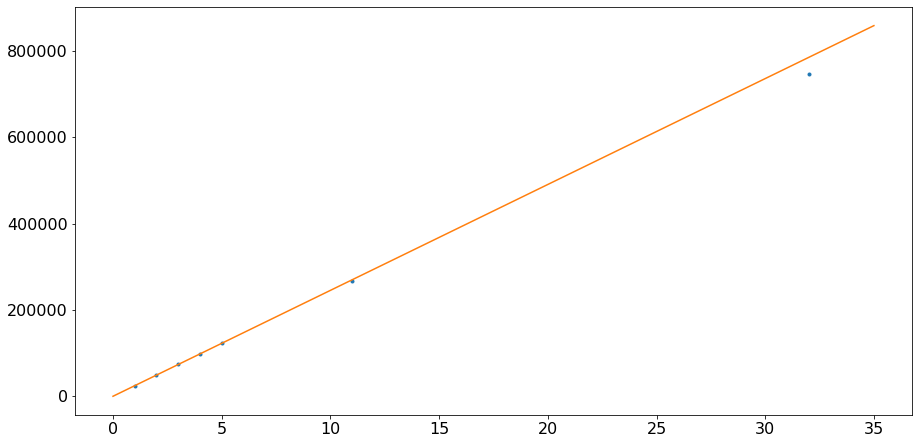

In [192]:
plt.plot(n_el, rates,'.')
n_arr = np.linspace(0,35,1000)
plt.plot(n_arr, b+r1*n_arr)
plt.show()

In [199]:
from scipy.optimize import minimize
b = 100*10/133
def f(p1_):
    rates_pred = f_ring*(1-np.exp(-p1_*n_el))+b
    return sum((rates-rates_pred)**2/rates_pred)
res = minimize(f,r1/f_ring)
print(res)
p1 = res.x[0]
rate1 = p1*f_ring
print("rate1 = ",rate1)

fun: 13.577048402673121
 hess_inv: array([[4.17337726e-12]])
      jac: array([1659.12860835])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 193
      nit: 3
     njev: 61
   status: 2
  success: False
        x: array([0.00328454])
rate1 =  24634.026437146105


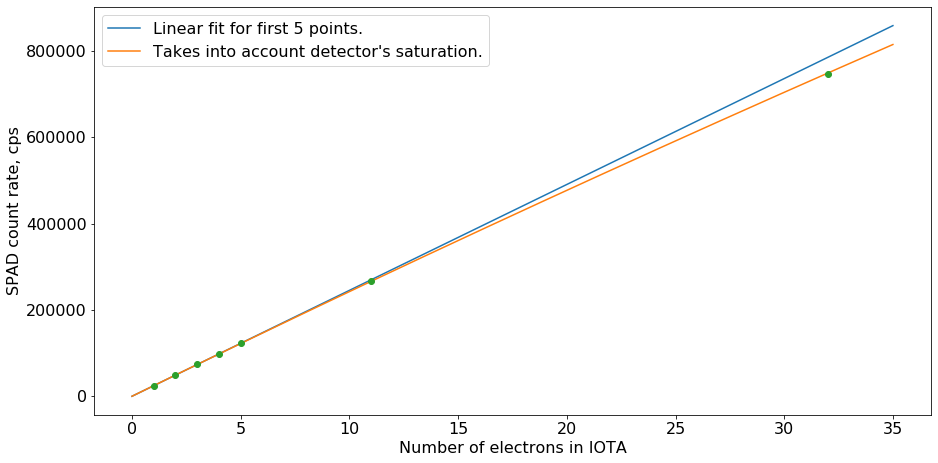

In [229]:
n_arr = np.linspace(0,35,1000)
plt.plot(n_arr, b+r1*n_arr, label="Linear fit for first 5 points.")
plt.plot(n_arr, f_ring*(1-np.exp(-p1*n_arr))+b, label="Takes into account detector's saturation.")
plt.plot(n_el, rates,marker='o',linestyle="None")
plt.ylabel("SPAD count rate, cps")
plt.xlabel("Number of electrons in IOTA")
plt.legend()
plt.show()

In [204]:
np.array([
            [1,1],
            [2,2],
            [3,3]
                 ]).shape

(3, 2)

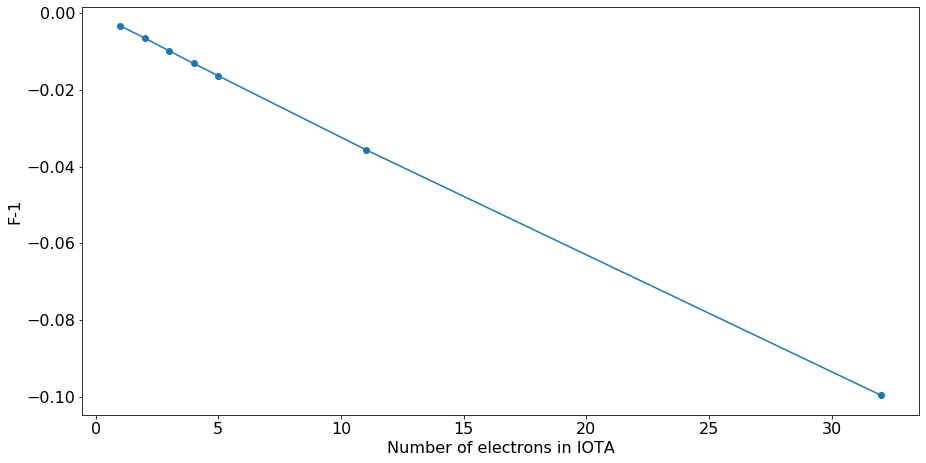

In [227]:
plt.errorbar(n_el, fano_mean_arr, yerr=[fano_error_bar_bottom,fano_error_bar_top],marker='o',linestyle="-")
plt.ylabel("F-1")
plt.xlabel("Number of electrons in IOTA")
plt.show()

In [230]:
rates[0]

24724.754869198612